# Description

* Determining how differences in our isopycnic cfg conditions vary in meaningful ways from those of Clay et al., 2003. Eur Biophys J
* Needed to determine whether the Clay et al., 2003 function describing diffusion is applicable to our data

> standard conditions from: Clay et al., 2003. Eur Biophys J

* Standard conditions:
	* 44k rev/min for Beckman XL-A
      * An-50 Ti Rotor
	* 44.77k rev/min for Beckman model E
	* 35k rev/min for preparative ultra-cfg & fractionation
      * De Sario et al., 1995: vertical rotor: VTi90 (Beckman)
        * 35k rpm for 16.5 h
* Our conditions:
	* speed (R) = 55k rev/min 
	* radius top/bottom (cm) = 2.6, 4.85
	* angular velocity: w = `((2 * 3.14159 * R)/60)^2`
    * TLA110 rotor

In [18]:
import numpy as np

In [3]:
%load_ext rpy2.ipython

In [26]:
%%R
library(ggplot2)
library(dplyr)


Attaching package: ‘dplyr’

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



### Beckman XL-A 

### Beckman model E

# Angular velocity (omega)

In [16]:
# angular velocity: our setup
angular_vel_f = lambda R: (2 * 3.14159 * R / 60)
print angular_vel_f(55000)

# angular velocity: De Sario et al., 1995
print angular_vel_f(35000)

5759.58166667
3665.18833333


# Meselson et al., 1957 equation on s.d. of band due to diffusion

\begin{equation}
\sigma^2 = \frac{RT}{M_{PX_n}\bar{\upsilon}_{PX_n} (\frac{dp}{dr})_{r_0} \omega^2 r_0}
\end{equation}

* R = gas constant
* T = temperature (C)
* M = molecular weight
  * PX_n = macromolecular electrolyte
* v = partial specific volume (mL/g)
* w = angular velocity
* r_0 = distance between the band center and rotor center
* dp/dr = density gradient

# Time to equilibrium: vertical rotor

radius_max - radius_min = width_of_tube

* VTi90 Rotor
  * radius_max = 71.1 mm
  * radius_min = 57.9 mm

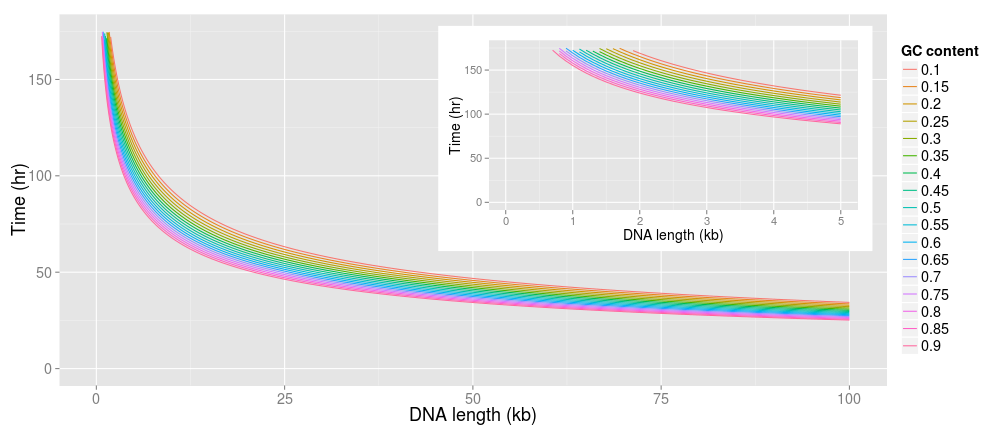

In [26]:
%%R -w 14 -h 6 -u in
library(ggplot2)
library(reshape)
library(grid)

# radius top,bottom (cm)
r.top = 57.9 / 10
r.bottom = 71.1 / 10

# isoconcentration point
I = sqrt((r.top^2 + r.top * r.bottom + r.bottom^2)/3)

# rpm
R = 35000

# particle density
D = 1.70

# beta^o
B = 1.14e9

# dna in bp from 0.1kb - 100kb
L = seq(100, 100000, 100)

# angular velocity
## 2*pi*rpm / 60
w = ((2 * 3.14159 * R)/60)^2

# DNA GC content
G.C = seq(0.1, 0.9, 0.05)

# Molecular weight
# M.W in relation to GC content (dsDNA)
A = 313.2
T = 304.2
C = 289.2
G = 329.2
GC = G + C
AT = A + T
#GC2MW = function(x){ x*GC + (1-x)*AT + 157 }  # assuming 5' monophosphate on end of molecules
GC2MW = function(x){ x*GC + (1-x)*AT  }
M.W = sapply(G.C, GC2MW)

# buoyant density
## GC_fraction = (p - 1.66) / 0.098
GC2buoyant.density = function(x){ (x * 0.098) + 1.66 }
B.D = GC2buoyant.density(G.C)

# radius of the isoconcentration point from cfg center (AKA: r.p)
## position of the particle at equilibrium 
buoyant.density2radius = function(x){ sqrt( ((x-D)*2*B/w) + I^2 ) }
P = buoyant.density2radius(B.D)

# calculating S
S.fun = function(L){ 2.8 + (0.00834 * (L*M.W)^0.479) }
S = t(sapply( L, S.fun ))

# calculating T 
T = matrix(ncol=17, nrow=length(L))
for(i in 1:ncol(S)){
    T[,i] = 1.13e14 * B * (D-1) / (R^4 * P[i]^2 * S[,i])
}

## formating
T = as.data.frame(T)
colnames(T) = G.C
T$dna_size__kb = L / 1000
T.m = melt(T, id.vars=c('dna_size__kb'))
colnames(T.m) = c('dna_size__kb', 'GC_content', 'time__h')
#T.m$GC_content = as.numeric(as.character(T.m$GC_content))

## plotting
p = ggplot(T.m, aes(dna_size__kb, time__h, color=GC_content, group=GC_content)) +
        geom_line() +
        scale_y_continuous(limits=c(0,175)) +
        labs(x='DNA length (kb)', y='Time (hr)') +
        scale_color_discrete(name='GC content') +
        #geom_hline(yintercept=66, linetype='dashed', alpha=0.5) +
        theme( text = element_text(size=18) )

#print(p)

# plotting at small scale
p.sub = ggplot(T.m, aes(dna_size__kb, time__h, color=GC_content, group=GC_content)) +
        geom_line() +
        scale_x_continuous(limits=c(0,5)) +
        scale_y_continuous(limits=c(0,175)) +
        labs(x='DNA length (kb)', y='Time (hr)') +
        scale_color_discrete(name='GC content') +
        #geom_hline(yintercept=66, linetype='dashed', alpha=0.5) +
        theme( 
            text = element_text(size=14),
            legend.position = 'none'
            ) 

vp = viewport(width=0.43, height=0.52, x = 0.65, y = 0.68)
print(p)
print(p.sub, vp=vp)


# Plotting band s.d. as defined the ultra-cfg technical manual

### density gradient
\begin{equation}
\frac{d\rho}{dr} = \frac{\omega^2r}{\beta}
\end{equation}

### band standard deviation
\begin{equation}
\sigma^2 = \frac{\theta}{M_{app}}\frac{RT}{(\frac{d\rho}{dr})_{eff} \omega^2r_o}
\end{equation}


### combined

\begin{equation}
\sigma^2 = \frac{\theta}{M_{app}}\frac{RT}{\frac{\omega^4r_o^2}{\beta}}
\end{equation}


### buoyant density of a molecule

\begin{equation}
\theta = \rho_i + \frac{\omega^2}{2\beta}(r_o^2 - r_1^2)
\end{equation}


### standard deviation due to diffusion (Clay et al., 2003)

\begin{equation}
\sigma_{diffusion}^2 = \Big(\frac{100%}{0.098}\Big)^2 \frac{\rho RT}{\beta_B^2GM_{Cs}} \frac{1}{1000l}
\end{equation}



In [196]:
%%R

# gas constant
R = 8.3144621e7 #J / mol*K

# temp
T = 273.15 + 23   # 23oC 

# rotor speed (rpm)
S = 55000

# beta^o
beta = 1.14 * 10^-9
#beta = 1.195 * 10^-10

# G
G = 7.87 * 10^10   #cgs 

# angular velocity
## 2*pi*rpm / 60
omega = 2 * pi * S /60

# GC
GC = seq(0,1,0.1)

# lengths
lens = seq(1000, 100000, 10000)

# molecular weight
GC2MW.dry = function(x){ 
    A = 313.2
    T = 304.2
    C = 289.2
    G = 329.2
    GC = G + C
    AT = A + T
    x*GC + (1-x)*AT  
}

M.dry = sapply(GC, GC2MW)

GC2MW.dryCS = function(n){
    #n = number of bases
    #base pair = 665 daltons
    #base pair per dry cesium DNA = 665 * 4/3 ~= 882
    return(n * 882)
    }

M.dryCS = sapply(lens, GC2MW.dryCS)


# BD
GC2BD = function(x){ 
    (x * 0.098) + 1.66 
    }
rho = sapply(GC, GC2BD)


# sd
calc_s.d = function(p=1.72, L=50000, T=298, B=1.195e9, G=7.87e-10, M=882){
    R = 8.3145e7
    x = (100 / 0.098)^2 * ((p*R*T)/(B^2*G*L*M))
    return(x)
    }

# run
p=seq(1.7, 1.75, 0.01)
L=seq(1000, 50000, 1000)
m = outer(p, L, calc_s.d)
rownames(m) = p
colnames(m) = L

         1000     2000     3000     4000     5000     6000     7000     8000
1.7  44.24560 22.12280 14.74853 11.06140 8.849119 7.374266 6.320799 5.530699
1.71 44.50586 22.25293 14.83529 11.12647 8.901173 7.417644 6.357981 5.563233
1.72 44.76613 22.38307 14.92204 11.19153 8.953226 7.461022 6.395162 5.595766
1.73 45.02640 22.51320 15.00880 11.25660 9.005280 7.504400 6.432343 5.628300
1.74 45.28667 22.64333 15.09556 11.32167 9.057334 7.547778 6.469524 5.660834
1.75 45.54694 22.77347 15.18231 11.38673 9.109387 7.591156 6.506705 5.693367
         9000    10000    11000    12000    13000    14000    15000    16000
1.7  4.916177 4.424560 4.022327 3.687133 3.403507 3.160400 2.949706 2.765350
1.71 4.945096 4.450586 4.045988 3.708822 3.423528 3.178990 2.967058 2.781616
1.72 4.974015 4.476613 4.069648 3.730511 3.443549 3.197581 2.984409 2.797883
1.73 5.002933 4.502640 4.093309 3.752200 3.463569 3.216171 3.001760 2.814150
1.74 5.031852 4.528667 4.116970 3.773889 3.483590 3.234762 3.019111 2.830417

In [58]:
%%R

# gas constant
R = 8.3144621e7 #J / mol*K

# temp
T = 273.15 + 23   # 23oC 

# rotor speed (rpm)
S = 55000

# beta^o
beta = 1.14 * 10^-9
#beta = 1.195 * 10^-10

# G
G = 7.87 * 10^10   #cgs 

# angular velocity
## 2*pi*rpm / 60
omega = 2 * pi * S /60

# GC
GC = seq(0,1,0.1)

# lengths
lens = seq(1000, 100000, 10000)

# molecular weight
GC2MW.dry = function(x){ 
    A = 313.2
    T = 304.2
    C = 289.2
    G = 329.2
    GC = G + C
    AT = A + T
    x*GC + (1-x)*AT  
}

#GC2MW = function(x){ x*GC + (1-x)*AT  }

M.dry = sapply(GC, GC2MW.dry)


GC2MW.dryCS = function(n){
    #n = number of bases
    #base pair = 665 daltons
    #base pair per dry cesium DNA = 665 * 4/3 ~= 882
    return(n * 882)
    }

M.dryCS = sapply(lens, GC2MW.dryCS)


# BD
GC2BD = function(x){ 
    (x * 0.098) + 1.66 
    }
rho = sapply(GC, GC2BD)


# sd
calc_s.d = function(p=1.72, L=50000, T=298, B=1.195e9, G=7.87e-10, M=882){
    R = 8.3145e7
    x = (100 / 0.098)^2 * ((p*R*T)/(B^2*G*L*M))
    return(sqrt(x))
    }

# run
p=seq(1.7, 1.75, 0.01)
L=seq(500, 50000, 500)
m = outer(p, L, calc_s.d)
rownames(m) = p
colnames(m) = L

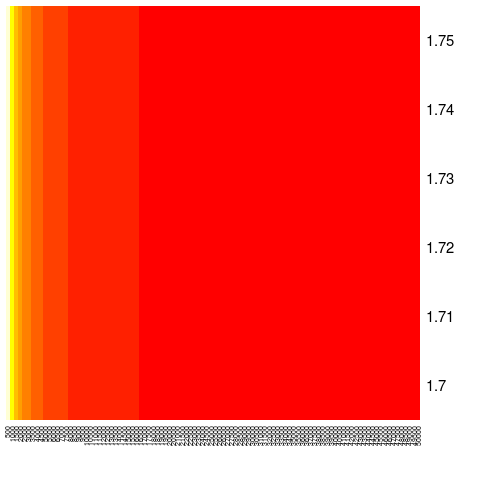

In [59]:
%%R
heatmap(m, Rowv=NA, Colv=NA)

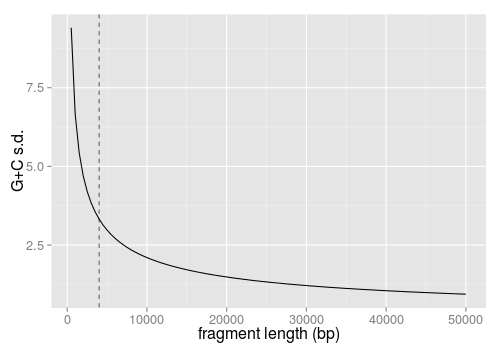

In [63]:
%%R -w 500 -h 350

df = as.data.frame(list('fragment_length'=as.numeric(colnames(m)), 'GC_sd'=m[1,]))
#df$GC_sd = sqrt(df$GC_var)

ggplot(df, aes(fragment_length, GC_sd)) +
    geom_line() +
    geom_vline(xintercept=4000, linetype='dashed', alpha=0.6) +
    labs(x='fragment length (bp)', y='G+C s.d.') +
    theme(
        text = element_text(size=16)
        )

__Notes:__

* Small fragment size (<4000 bp) leads to large standard deviations in realized G+C

In [70]:
%%R
calc_s.d = function(p=1.72, L=50000, T=298, B=1.195e9, G=7.87e-10, M=882){
    R = 8.3145e7
    sigma_sq = (p*R*T)/(B^2*G*L*M)
    return(sqrt(sigma_sq))    
    }

# run
p=seq(1.7, 1.75, 0.01)
L=seq(500, 50000, 500)
m = outer(p, L, calc_s.d)
rownames(m) = p
colnames(m) = L
head(m)

             500        1000        1500        2000        2500        3000
1.7  0.009218836 0.006518702 0.005322498 0.004609418 0.004122789 0.003763574
1.71 0.009245911 0.006537846 0.005338129 0.004622955 0.004134897 0.003774627
1.72 0.009272906 0.006556935 0.005353715 0.004636453 0.004146970 0.003785648
1.73 0.009299823 0.006575968 0.005369255 0.004649912 0.004159007 0.003796637
1.74 0.009326662 0.006594946 0.005384751 0.004663331 0.004171010 0.003807594
1.75 0.009353425 0.006613870 0.005400202 0.004676712 0.004182979 0.003818520
            3500        4000        4500        5000        5500        6000
1.7  0.003484393 0.003259351 0.003072945 0.002915252 0.002779584 0.002661249
1.71 0.003494626 0.003268923 0.003081970 0.002923814 0.002787747 0.002669064
1.72 0.003504829 0.003278467 0.003090969 0.002932350 0.002795886 0.002676857
1.73 0.003515003 0.003287984 0.003099941 0.002940862 0.002804002 0.002684628
1.74 0.003525147 0.003297473 0.003108887 0.002949350 0.002812095 0.002692376

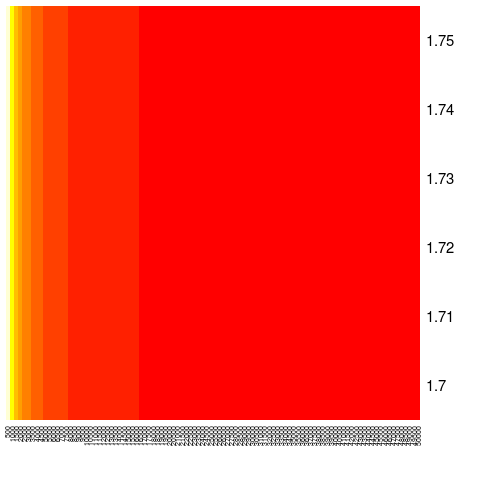

In [66]:
%%R
heatmap(m, Rowv=NA, Colv=NA)

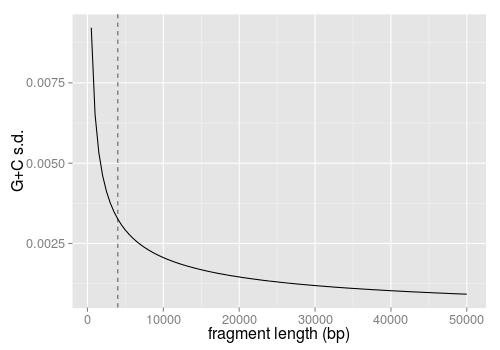

In [79]:
%%R -w 500 -h 350

BD50 = 0.098 * 0.5 + 1.66

df = as.data.frame(list('fragment_length'=as.numeric(colnames(m)), 'BD_sd'=m[BD50,]))

ggplot(df, aes(fragment_length, BD_sd)) +
    geom_line() +
    geom_vline(xintercept=4000, linetype='dashed', alpha=0.6) +
    labs(x='fragment length (bp)', y='G+C s.d.') +
    theme(
        text = element_text(size=16)
        )